In [253]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## Problem 2

Steady state temperature $T_ss$ obtained in Problem 1

$$
T_{ss} = - \frac{c e^{-ax}}{a^{2}k} + \frac{x}{L}\left[ T_{0} - \frac{c}{a^{2}k}(1-e^{-aL}) \right] + \frac{c}{a^2 k}
$$

where $c$ and $a$ are constants.

Before going to the problem, consider the units of $c$.  
$[c] = [W \cdot m]$

In [254]:
# define parameters
L = 0.5     # [m]
a = 5       # [1/m]
k = 1.28    # [W/mK] -> equiv to [W/mC]
T = 0
T0 = 20

# position
x = np.linspace(0, L, 100)

In [255]:
# vary value of c
def temp(x, c):
    return - c * np.exp(-a*x)/(a**2 * k) + x/L * (T0 - c/(a**2 * k) * (1 - np.exp(-a*L))) + c/(a**2 * k)

### Task 1

Vary your value of $c$ to see how it changes the temperature profile.

(Answer)

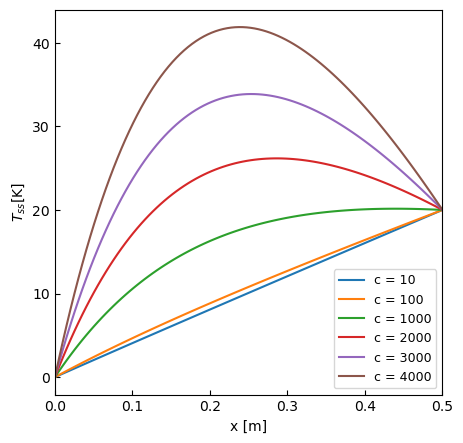

In [256]:
c = np.array([10**1, 10**2, 10**3, 2*10**3, 3*10**3, 4*10**3])

fig, ax = plt.subplots(1,1, figsize=(5,5))

for i in range(len(c)):
    ax.plot(x, temp(x, c[i]), label='c = ' + str(c[i]))


ax.set_xlabel('x [m]')
ax.set_ylabel(r'$T_{ss}$[K]')
ax.set_xlim(0, 0.5)
plt.legend(fontsize=9)

plt.savefig('HW6_Problem_2.png', dpi=300, bbox_inches = 'tight')
plt.show()

### (Helper functions)

In [257]:
# central difference method (second-order approximation)
def numerical_derivative(f, x, c, h=1e-8):
    return (f(x + h, c) - f(x - h, c)) / (2*h)

# Wrapper function for the derivative to pass to the root-finding algorithm
def derivative_wrapper(x, c):
    return numerical_derivative(temp, x, c)


def root_search(c, init = 0.0):
    return optimize.newton(derivative_wrapper, init, args=(c,))


In [258]:
'''
# test
c_test = 4 *10**3
print(root_search(c = c_test))
print(temp(root_search(c = c_test), c_test))
'''

'\n# test\nc_test = 4 *10**3\nprint(root_search(c = c_test))\nprint(temp(root_search(c = c_test), c_test))\n'

### Task 2
For waht value of $c$, the maximum temperature in the wall is 40 C.

In [259]:
# set a search space
_start = 3.5 * 10**3
_stop =  4.0 * 10**3
c_test = np.arange(_start, _stop, 0.1)

In [260]:
def target_function(c):
    root = root_search(c)
    return temp(root, c) - 40

(Answer)

In [261]:
# Search for the value of c in c_test domain
for c in c_test:
    try:
        if np.isclose(target_function(c), 0, atol=1e-2):
            print(f'Found c: {c}')
            break
    except:
        pass
else:
    print('Change the range of search domain')

Found c: 3766.199999999758


### Task 3

For each value of $c$ determine the maximum temperature, and the location of the peak temperature.

(Answer)

In [262]:
c_test = np.arange(_start, _stop, 50)
print('value of c \n',c_test)

# locations maximum temperature for each c_test
roots = np.array([root_search(c) for c in c_test])
print('locations \n',roots)

# maximum temperature
results = temp(roots, c_test)
print('max. temp \n',results)

value of c 
 [3500. 3550. 3600. 3650. 3700. 3750. 3800. 3850. 3900. 3950.]
locations 
 [0.24481936 0.24411984 0.24344208 0.24278509 0.24214792 0.24152969
 0.24092955 0.24034673 0.23978049 0.23923011]
max. temp 
 [37.85075754 38.25178585 38.65320212 39.05498914 39.45713073 39.8596116
 40.26241737 40.66553444 41.06894997 41.4726518 ]


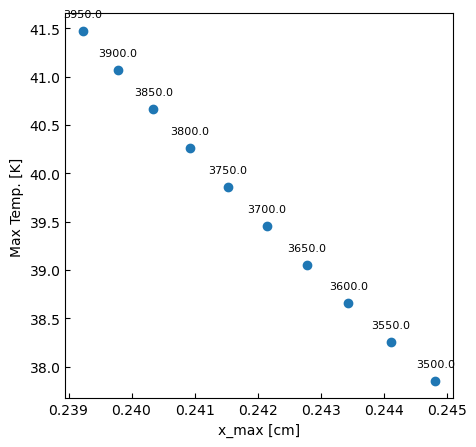

In [263]:
fig, ax = plt.subplots(1,1, figsize=(5,5))


ax.plot(roots, results, marker='o', ls='')
for root, result, c in zip(roots, results, c_test):
    ax.annotate(f'{c}', (root, result), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)


ax.set_xlabel('x_max [cm]')
ax.set_ylabel('Max Temp. [K]')
plt.show()

## Problem 3

Finite Difference Method (FDM) - Iterative
- the Gauss-Seidel iterative method

### Tasks
- Show the results of the grid refinement study on one plot. (Plot $T$ as a function of
$x$ for different values of $\Delta x$)
- Tabulate the values of the maximum temperature determined numerically vs $\Delta x$ (grid size).
- Show the exact and the numerically determined temperature profiles on one plot

(Answer)

- The search domain: $c \in (1000, 4000)$
- For the number of grid points $n$, $\Delta x$ can be converted by the following:  
$$
\Delta x = \frac{L}{n-1}
$$

- Grid Refinement Study: the numbers of grids are updated by
$$
n_{j+1} = n_{j} * j^{2}
$$
where subscript $j$ represents the number of refinement trials. In this study $j=0, 1, 2, 3$ and the initnial value is $n_{0} = n_{initial} = 10$.

Optimal c value: 1362.205088106454
Grid size 20 leads to an error below the threshold of 0.5%
Grid size 40 leads to an error below the threshold of 0.5%
Grid size 80 leads to an error below the threshold of 0.5%


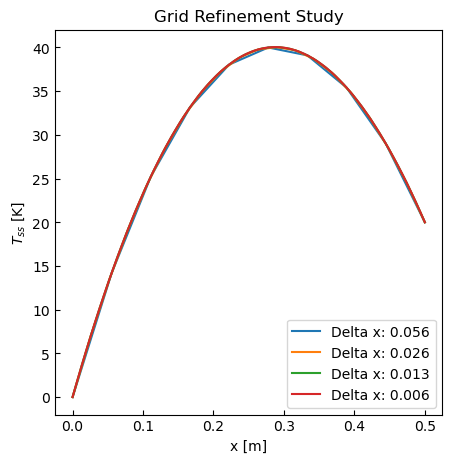

    Delta x  Grid Size  Max Temperature
0  0.055556         10        40.000000
1  0.026316         20        40.045759
2  0.012821         40        40.032469
3  0.006329         80        40.043027


In [272]:
import pandas as pd
from scipy.optimize import minimize_scalar

# parameters (same as the previous problem)
L = 0.5
k = 1.28
a = 0.5
n_initial = 10  # Initial grid size
tolerance = 1e-6
error_threshold = 0.005  # 0.5% error

# Function to compute the maximum temperature for a given c value
def compute_max_temp(c, n):
    dx = L / (n - 1)
    phi = np.zeros(n)
    phi[0] = 0
    phi[-1] = 20
    error = 1.0
    
    while error > tolerance:
        phi_old = phi.copy()
        for i in range(1, n-1):
            a_ii = -2
            a_i_minus_1 = 1
            a_i_plus_1 = 1
            source_i = -c * dx**2 * np.exp(-a * i * dx) / k
            phi[i] = (1 / a_ii) * (source_i - a_i_minus_1 * phi[i-1] - a_i_plus_1 * phi[i+1])
        error = np.max(np.abs(phi - phi_old))
    
    return np.max(phi), phi

def objective(c):
    return abs(compute_max_temp(c, n_initial)[0] - 40)

# Find the optimal c value
result = minimize_scalar(objective, bounds=(1000, 4000), method='bounded')
optimal_c = result.x
print(f'Optimal c value: {optimal_c}')

grid_sizes = [n_initial * 2**i for i in range(4)]  # Example grid sizes
x_sizes = [] # Delta x
max_temps = []

fig, ax = plt.subplots(1,1, figsize=(5,5))

# Compute the first grid size outside the loop to initialize prev_max_temp
n = grid_sizes[0]
max_temp, phi = compute_max_temp(optimal_c, n)
max_temps.append(max_temp)
x = np.linspace(0, L, n)
del_x = L/(n-1)
x_sizes.append(del_x)
ax.plot(x, phi, label=f'Delta x: {del_x:.3f}')

prev_max_temp = max_temp  # initialize prev_max_temp

# Now loop through the remaining grid sizes
for n in grid_sizes[1:]:
    max_temp, phi = compute_max_temp(optimal_c, n)
    
    # Compute the error
    error = abs((max_temp - prev_max_temp) / max_temp)
    if error < error_threshold:
        print(f'Grid size {n} leads to an error below the threshold of 0.5%')

    
    prev_max_temp = max_temp  # Update prev_max_temp for the next iteration
    
    max_temps.append(max_temp)
    x = np.linspace(0, L, n)
    del_x = L/(n-1)
    x_sizes.append(del_x)
    ax.plot(x, phi, label=f'Delta x: {del_x:.3f}')

ax.set_xlabel('x [m]')
ax.set_ylabel(r'$T_{ss}$ [K]')
ax.set_title('Grid Refinement Study')
ax.legend()
plt.show()

# Tabulate Maximum Temperatures
df = pd.DataFrame({'Delta x': x_sizes, 'Grid Size': grid_sizes[:len(max_temps)], 'Max Temperature': max_temps})
print(df)